<a href="https://colab.research.google.com/github/atishSanyal03/protein-ligand_Prediction/blob/master/Pro_Lig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

## Install visualization packages required by Keras
Restart runtime after running the following cell

In [0]:
!pip install graphviz pydot
!apt install graphviz

## Tensorboard support

In [0]:
!pip install tensorboardcolab

  Running setup.py bdist_wheel for tensorboardcolab ... - done
  Stored in directory: /root/.cache/pip/wheels/ab/74/02/cda602d1dc28b2f12eab313c49b9bfa14d6371326bc2590e06
Successfully built tensorboardcolab


In [0]:
from tensorboardcolab import *

## Perform imports

In [0]:
import keras.backend as K
import matplotlib.pyplot as plt
import itertools
import numpy as np
import random
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv3D, MaxPooling3D,Flatten,Dense, Dropout, BatchNormalization, Add, AveragePooling3D, Activation, GaussianNoise
from keras import optimizers, losses, regularizers
from keras.optimizers import Adam, SGD
from keras.initializers import glorot_normal
from keras.utils import plot_model, Sequence
from keras.activations import relu
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from tqdm import tqdm, trange
import tensorflow as tf
import os

Using TensorFlow backend.


## Define util functions

In [0]:
# Reads a up to spec pdb file and return a tuple of the
# atoms' x, y, z and atomtype
def read_pdb(filename):
	with open(filename, 'r') as file:
		strline_L = file.readlines()
	X_list = list()
	Y_list = list()
	Z_list = list()
	atomtype_list = list()
	for strline in strline_L:
		# removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
		stripped_line = strline.strip()

		line_length = len(stripped_line)
		# print("Line length:{}".format(line_length))
		if line_length < 78:
			print("ERROR: line length is different. Expected>=78, current={}".format(line_length))
		
		X_list.append(float(stripped_line[30:38].strip()))
		Y_list.append(float(stripped_line[38:46].strip()))
		Z_list.append(float(stripped_line[46:54].strip()))

		atomtype = stripped_line[76:78].strip()
		if atomtype == 'C':
			atomtype_list.append('h') # 'h' means hydrophobic
		else:
			atomtype_list.append('p') # 'p' means polar

	return (X_list, Y_list, Z_list, atomtype_list)

In [0]:
# Reads the test pdb file and return a tuple of the
# atoms' x, y, z and atomtype
def read_test_pdb(filename):
	with open(filename, 'r') as file:
		strline_L = file.readlines()
	X_list = list()
	Y_list = list()
	Z_list = list()
	atomtype_list = list()
	for strline in strline_L:
		# removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
		stripped_line = strline.strip()
		tokens = stripped_line.split("\t")
        
		X_list.append(float(tokens[0]))
		Y_list.append(float(tokens[1]))
		Z_list.append(float(tokens[2]))
		atomtype_list.append(tokens[3])

	return (X_list, Y_list, Z_list, atomtype_list)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
def mcc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


# Import raw training data

## Download and unzip the training data

In [0]:
!wget https://web.bii.a-star.edu.sg/~leehk/cs5242_project/training_data.zip
!unzip training_data.zip

## Load training data into memory

In [0]:
raw_training_data = {
    'pro': [],
    'lig': []
}
for i in trange(3000):
    raw_training_data['pro'].append(
        read_pdb("./training_data/{:04d}_pro_cg.pdb".format(i + 1)))
    raw_training_data['lig'].append(
        read_pdb("./training_data/{:04d}_lig_cg.pdb".format(i + 1)))

100%|██████████| 3000/3000 [00:09<00:00, 304.52it/s]


In [0]:
n = int(len(raw_training_data['pro'])*0.9)
raw_training_train_data = {
    'pro': raw_training_data['pro'][:n],
    'lig': raw_training_data['lig'][:n]
}
raw_training_test_data = {
    'pro': raw_training_data['pro'][n:],
    'lig': raw_training_data['lig'][n:]
}

# Preprocess training data

## Download script requried for voxelization

In [0]:
!wget https://gitlab.com/cheminfIBB/tfbio/raw/master/tfbio/data.py -O tfbio_data.py
!pip install pybel

--2018-11-02 17:27:21--  https://gitlab.com/cheminfIBB/tfbio/raw/master/tfbio/data.py
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20089 (20K) [text/plain]
Saving to: ‘tfbio_data.py’

tfbio_data.py       100%[===================>]  19.62K  --.-KB/s    in 0s      

2018-11-02 17:27:21 (158 MB/s) - ‘tfbio_data.py’ saved [20089/20089]

    100% |████████████████████████████████| 337kB 8.9MB/s 
    100% |████████████████████████████████| 5.7MB 4.8MB/s 
    100% |████████████████████████████████| 81kB 22.4MB/s 
  Running setup.py bdist_wheel for pybel ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/8c/df/69/e4b14b32cac41f6058e3381341a1c6373e3dc6a00062b89e4b
  Running setup.py bdist_wheel for sqlalchemy ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/ba/2e/47/b194b03e6aeaa658f521dfba094a42f1d37f4ee401

## Define voxelization functions

In [0]:
from tfbio_data import make_grid
# Voxelizes a protein and ligand input together
# pdb_inputs[0] should contain the protein data as returned by read_pdb
# pdb_inputs[1] should contain the ligand data as returned by read_pdb
def voxelize(pdb_inputs, max_dist=20, grid_resolution=4):
    
    X_prot, Y_prot, Z_prot, atomtype_prot = pdb_inputs[0]
    X_lig, Y_lig, Z_lig, atomtype_lig = pdb_inputs[1]
    
    X_prot = np.asarray(X_prot)
    Y_prot = np.asarray(Y_prot)
    Z_prot = np.asarray(Z_prot)
    
    X_lig = np.asarray(X_lig)
    Y_lig = np.asarray(Y_lig)
    Z_lig = np.asarray(Z_lig)
    
    A_prot = np.vstack((np.vstack((X_prot.T,Y_prot.T)),Z_prot.T)).T
    A_lig = np.vstack((np.vstack((X_lig.T,Y_lig.T)),Z_lig.T)).T
    coord_matrix = np.hstack((A_prot.T,A_lig.T)).T
    
    A_prot_type = np.asarray([127 if x=='h' else 255 for x in atomtype_prot])
    A_lig_type = np.asarray([127 if x=='h' else 255 for x in atomtype_lig])
    
    prot_marker = 127*np.ones(X_prot.size)
    lig_marker = 255*np.ones(X_lig.size)
    
    marker_matrix = np.expand_dims(np.hstack((prot_marker.T,lig_marker.T)).T,axis=1)
    type_matrix = np.expand_dims(np.hstack((A_prot_type.T,A_lig_type.T)).T,axis=1)
    feat_matrix = np.hstack((marker_matrix,type_matrix))
    
    coord_matrix = coord_matrix - np.mean(A_lig,axis=0)
    
    grid = make_grid(coord_matrix,feat_matrix,max_dist=max_dist,grid_resolution=grid_resolution)
        
    return grid

In [0]:
# Returns a tuple containg the training data and corresponding labels
# ratio specifies the number of negative training examples generated
# per positive training example
def generate_training_data(raw_data, pos_ratio=1, neg_ratio=1, max_dist=20, grid_resolution=4, quiet=False):
    n = len(raw_data['pro'])
    x_all = []
    y_all = []
    for i in tqdm(range(n), disable=quiet):
        for _ in range(pos_ratio):
            grid = voxelize((
                raw_data['pro'][i],
                raw_data['lig'][i]
            ), max_dist, grid_resolution)
            x_all.append(grid[0])
            y_all.append([1.])
        for _ in range(neg_ratio):
            grid = voxelize((
                raw_data['pro'][i],
                raw_data['lig'][random.choice(list(range(i)) + list(range(i+1, n)))]
            ), max_dist, grid_resolution)
            x_all.append(grid[0])
            y_all.append([0.])
    return np.asarray(x_all), np.asarray(y_all)
    

## Define Keras Sequence for dymanically generating samples

In [0]:
class ProLigSequence(Sequence):

    def __init__(self, raw_data, max_dist=20, grid_resolution=4, batch_size=128):
        self.raw_data = raw_data
        self.max_dist = max_dist
        self.grid_resolution = grid_resolution
        self.batch_size = batch_size
        self.pos_eg_x, self.pos_eg_y = generate_training_data(raw_data, neg_ratio=0, max_dist=max_dist, grid_resolution=grid_resolution, quiet=True)
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.all_eg_x) / float(self.batch_size)))

    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = self.all_eg_x[indexes]
        batch_y = self.all_eg_y[indexes]

        return batch_x, batch_y

    def on_epoch_end(self):
        # Generate a new set of negative training examples
        self.neg_eg_x, self.neg_eg_y = generate_training_data(
            self.raw_data,
            pos_ratio=0,
            max_dist=self.max_dist,
            grid_resolution=self.grid_resolution,
            quiet=True
        )
        self.all_eg_x = np.concatenate((self.pos_eg_x, self.neg_eg_x))
        self.all_eg_y = np.concatenate((self.pos_eg_y, self.neg_eg_y))
        self.indexes = np.arange(len(self.all_eg_x))
        np.random.shuffle(self.indexes)

# Define Wide ResNet

In [0]:
# k defines the width of the network as defined in the Wide ResNet paper
def generate_resnet(input_shape, k=1, noise=False,
                    l1_filters=16, l1_kernel_size=3, l1_dilation_rate=1):
    inputs = Input(shape=input_shape)
    x = inputs
    if noise == True:
        x = GaussianNoise(25)(x)
    x = Conv3D(
        filters=l1_filters,
        kernel_size=l1_kernel_size,
        dilation_rate=l1_dilation_rate,
        padding='valid',
        data_format='channels_last'
    )(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x2 = Conv3D(
        filters=32*k,
        kernel_size=1,
        padding='same',
        data_format='channels_last',
    )(x)
    x1 = Conv3D(
        filters=32*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
    )(x)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=32*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
    )(x1)
    x = Add()([x1, x2])

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x2 = Conv3D(
        filters=64*k,
        kernel_size=1,
        padding='same',
        data_format='channels_last',
    )(x)
    x1 = Conv3D(
        filters=64*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
    )(x)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=64*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
    )(x1)
    x = Add()([x1, x2])

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x2 = Conv3D(
        filters=128*k,
        kernel_size=1,
        padding='same',
        data_format='channels_last',
    )(x)
    x1 = Conv3D(
        filters=128*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
    )(x)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=128*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
    )(x1)
    x = Add()([x1, x2])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = AveragePooling3D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)


# Tests with small vox size

## Generate training data

In [0]:
x_all, y_all = generate_training_data(raw_training_data, max_dist=20, grid_resolution=4)
n = x_all.shape[0]
x_train = x_all[:int(n*0.9)]
y_train = y_all[:int(n*0.9)]
x_test = x_all[int(n*0.9):]
y_test = y_all[int(n*0.9):]

100%|██████████| 3000/3000 [00:12<00:00, 241.26it/s]


## Generate 4 different networks with differing noise layer and first conv filters count

In [0]:
models = {}


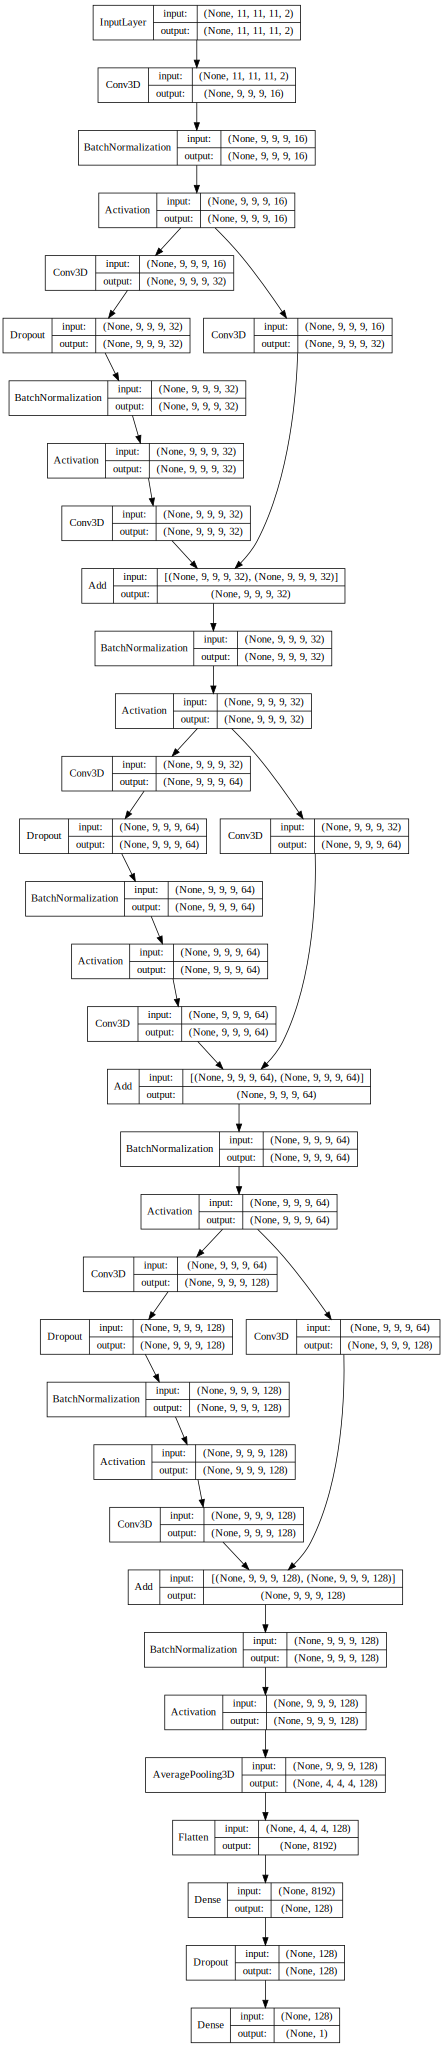

In [0]:
models['Quiet64'] = generate_resnet(x_train[0].shape, noise=False, l1_filters=16)
models['Quiet256'] = generate_resnet(x_train[0].shape, noise=False, l1_filters=256)
models['Noisy64'] = generate_resnet(x_train[0].shape, noise=True, l1_filters=16)
models['Noisy256'] = generate_resnet(x_train[0].shape, noise=True, l1_filters=256)
SVG(model_to_dot(models['Quiet64'], show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))


## Train each model

In [0]:
histories = {}

In [0]:
models['Quiet64'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam(amsgrad=True)
)
history1 = models['Quiet64'].fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test))
models['Quiet64'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)

)
history2 = models['Quiet64'].fit(x_train, y_train, batch_size=128, epochs=120, validation_data=(x_test, y_test))

histories['Quiet64'] = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'acc': history1.history['acc'] + history2.history['acc'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_acc': history1.history['val_acc'] + history2.history['val_acc'],

}

Train on 5400 samples, validate on 600 samples
Epoch 1/30
5400/5400 [==============================] - 53s 10ms/step - loss: 1.2206 - acc: 0.8906 - val_loss: 1.5290 - val_acc: 0.9000
Epoch 2/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.8686 - acc: 0.9250 - val_loss: 1.1843 - val_acc: 0.8967
Epoch 3/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.7385 - acc: 0.9228 - val_loss: 1.4038 - val_acc: 0.5283
Epoch 4/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.5815 - acc: 0.9039 - val_loss: 1.1609 - val_acc: 0.8917
Epoch 5/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.6105 - acc: 0.9091 - val_loss: 1.5030 - val_acc: 0.9033
Epoch 6/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.6633 - acc: 0.9194 - val_loss: 1.0775 - val_acc: 0.9233
Epoch 7/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.6506 - acc: 0.9165 - val_loss: 1.5433 - val_acc: 0.8983
Epoch 8

In [0]:
models['Quiet256'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam(amsgrad=True)
)
history1 = models['Quiet256'].fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test))
models['Quiet256'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)

)
history2 = models['Quiet256'].fit(x_train, y_train, batch_size=128, epochs=120, validation_data=(x_test, y_test))

histories['Quiet256'] = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'acc': history1.history['acc'] + history2.history['acc'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_acc': history1.history['val_acc'] + history2.history['val_acc'],

}

Train on 5400 samples, validate on 600 samples
Epoch 1/30
5400/5400 [==============================] - 60s 11ms/step - loss: 1.0078 - acc: 0.9026 - val_loss: 1.3949 - val_acc: 0.9033
Epoch 2/30
5400/5400 [==============================] - 28s 5ms/step - loss: 0.7796 - acc: 0.9161 - val_loss: 0.9688 - val_acc: 0.5800
Epoch 3/30
5400/5400 [==============================] - 28s 5ms/step - loss: 0.7601 - acc: 0.9180 - val_loss: 0.9658 - val_acc: 0.9233
Epoch 4/30
5400/5400 [==============================] - 28s 5ms/step - loss: 0.5277 - acc: 0.9176 - val_loss: 0.8871 - val_acc: 0.8817
Epoch 5/30
5400/5400 [==============================] - 28s 5ms/step - loss: 0.5396 - acc: 0.9070 - val_loss: 1.1384 - val_acc: 0.9150
Epoch 6/30
5400/5400 [==============================] - 28s 5ms/step - loss: 0.3901 - acc: 0.9106 - val_loss: 0.4007 - val_acc: 0.9367
Epoch 7/30
5400/5400 [==============================] - 28s 5ms/step - loss: 0.3003 - acc: 0.9191 - val_loss: 0.3386 - val_acc: 0.9200
Epoch 8

In [0]:
models['Noisy64'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam(amsgrad=True)
)
history1 = models['Noisy64'].fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test))
models['Noisy64'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)

)
history2 = models['Noisy64'].fit(x_train, y_train, batch_size=128, epochs=120, validation_data=(x_test, y_test))

histories['Noisy64'] = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'acc': history1.history['acc'] + history2.history['acc'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_acc': history1.history['val_acc'] + history2.history['val_acc'],

}

Train on 5400 samples, validate on 600 samples
Epoch 1/30
5400/5400 [==============================] - 54s 10ms/step - loss: 1.0179 - acc: 0.9041 - val_loss: 1.3580 - val_acc: 0.9067
Epoch 2/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.4655 - acc: 0.8957 - val_loss: 0.4732 - val_acc: 0.9083
Epoch 3/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.2800 - acc: 0.9215 - val_loss: 0.3484 - val_acc: 0.9233
Epoch 4/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.2081 - acc: 0.9272 - val_loss: 0.2353 - val_acc: 0.9067
Epoch 5/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.1993 - acc: 0.9311 - val_loss: 0.4133 - val_acc: 0.9300
Epoch 6/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.1696 - acc: 0.9391 - val_loss: 0.2441 - val_acc: 0.9083
Epoch 7/30
5400/5400 [==============================] - 21s 4ms/step - loss: 0.1517 - acc: 0.9437 - val_loss: 0.4428 - val_acc: 0.9383
Epoch 8

In [0]:
models['Noisy256'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam(amsgrad=True)
)
history1 = models['Noisy256'].fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test))
models['Noisy256'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)

)
history2 = models['Noisy256'].fit(x_train, y_train, batch_size=128, epochs=120, validation_data=(x_test, y_test))

histories['Noisy256'] = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'acc': history1.history['acc'] + history2.history['acc'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_acc': history1.history['val_acc'] + history2.history['val_acc'],

}

Train on 5400 samples, validate on 600 samples
Epoch 1/30
5400/5400 [==============================] - 62s 11ms/step - loss: 1.2806 - acc: 0.8896 - val_loss: 1.3069 - val_acc: 0.9117
Epoch 2/30
5400/5400 [==============================] - 27s 5ms/step - loss: 0.8918 - acc: 0.9241 - val_loss: 0.8498 - val_acc: 0.7650
Epoch 3/30
5400/5400 [==============================] - 27s 5ms/step - loss: 0.8172 - acc: 0.9106 - val_loss: 1.3313 - val_acc: 0.9050
Epoch 4/30
5400/5400 [==============================] - 27s 5ms/step - loss: 0.6622 - acc: 0.9113 - val_loss: 0.6508 - val_acc: 0.7583
Epoch 5/30
5400/5400 [==============================] - 27s 5ms/step - loss: 0.5308 - acc: 0.9196 - val_loss: 0.2707 - val_acc: 0.9300
Epoch 6/30
5400/5400 [==============================] - 27s 5ms/step - loss: 0.3612 - acc: 0.9231 - val_loss: 0.6787 - val_acc: 0.7600
Epoch 7/30
5400/5400 [==============================] - 27s 5ms/step - loss: 0.5379 - acc: 0.9178 - val_loss: 1.7674 - val_acc: 0.8883
Epoch 8

## Plot loss and accuracy

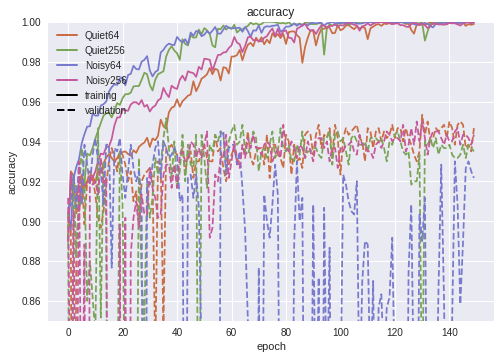

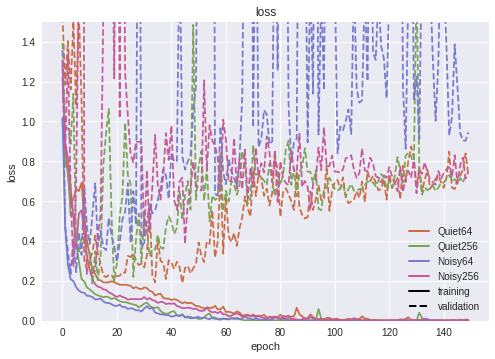

In [0]:
from matplotlib.lines import Line2D
# summarize history for accuracy
plt.plot(histories['Quiet64']['acc'], color='#c96d44')
plt.plot(histories['Quiet256']['acc'], color='#7aa456')
plt.plot(histories['Noisy64']['acc'], color='#777acd')
plt.plot(histories['Noisy256']['acc'], color='#c65999')
plt.plot(histories['Quiet64']['val_acc'], color='#c96d44', linestyle='--')
plt.plot(histories['Quiet256']['val_acc'], color='#7aa456', linestyle='--')
plt.plot(histories['Noisy64']['val_acc'], color='#777acd', linestyle='--')
plt.plot(histories['Noisy256']['val_acc'], color='#c65999', linestyle='--')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(top=1)
plt.ylim(bottom=0.85)
legend_elements = [Line2D([0], [0], color='#c96d44', lw=2),
                    Line2D([0], [0], color='#7aa456', lw=2),
                    Line2D([0], [0], color='#777acd', lw=2),
                    Line2D([0], [0], color='#c65999', lw=2),
                    Line2D([0], [0], color='k', lw=2),
                    Line2D([0], [0], color='k', lw=2, linestyle='--')]
plt.legend(legend_elements, ['Quiet64', 'Quiet256', 'Noisy64', 'Noisy256', 'training', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histories['Quiet64']['loss'], color='#c96d44')
plt.plot(histories['Quiet256']['loss'], color='#7aa456')
plt.plot(histories['Noisy64']['loss'], color='#777acd')
plt.plot(histories['Noisy256']['loss'], color='#c65999')
plt.plot(histories['Quiet64']['val_loss'], color='#c96d44', linestyle='--')
plt.plot(histories['Quiet256']['val_loss'], color='#7aa456', linestyle='--')
plt.plot(histories['Noisy64']['val_loss'], color='#777acd', linestyle='--')
plt.plot(histories['Noisy256']['val_loss'], color='#c65999', linestyle='--')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(top=1.5)
plt.ylim(bottom=0)
legend_elements = [Line2D([0], [0], color='#c96d44', lw=2),
                    Line2D([0], [0], color='#7aa456', lw=2),
                    Line2D([0], [0], color='#777acd', lw=2),
                    Line2D([0], [0], color='#c65999', lw=2),
                    Line2D([0], [0], color='k', lw=2),
                    Line2D([0], [0], color='k', lw=2, linestyle='--')]
plt.legend(legend_elements, ['Quiet64', 'Quiet256', 'Noisy64', 'Noisy256', 'training', 'validation'], loc='lower right')
plt.show()

# Tests between small and large vox size

In [0]:
models = {}
histories = {}

## Generate model and training data for small vox size

In [0]:
x_all, y_all = generate_training_data(raw_training_data, max_dist=20, grid_resolution=4)
n = x_all.shape[0]
x_train = x_all[:int(n*0.9)]
y_train = y_all[:int(n*0.9)]
x_test = x_all[int(n*0.9):]
y_test = y_all[int(n*0.9):]

100%|██████████| 3000/3000 [00:11<00:00, 259.50it/s]


In [0]:
models['SmallVox'] = generate_resnet(x_train[0].shape, noise=False, l1_filters=16)

In [0]:
models['SmallVox'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam()
)
history1 = models['SmallVox'].fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))
models['SmallVox'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)

)
history2 = models['SmallVox'].fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

histories['SmallVox'] = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'acc': history1.history['acc'] + history2.history['acc'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_acc': history1.history['val_acc'] + history2.history['val_acc'],

}

## Generate model and training data for large vox size

In [0]:
x_all, y_all = generate_training_data(raw_training_data, max_dist=40, grid_resolution=2)
n = x_all.shape[0]
x_train = x_all[:int(n*0.9)]
y_train = y_all[:int(n*0.9)]
x_test = x_all[int(n*0.9):]
y_test = y_all[int(n*0.9):]

100%|██████████| 3000/3000 [00:22<00:00, 132.48it/s]


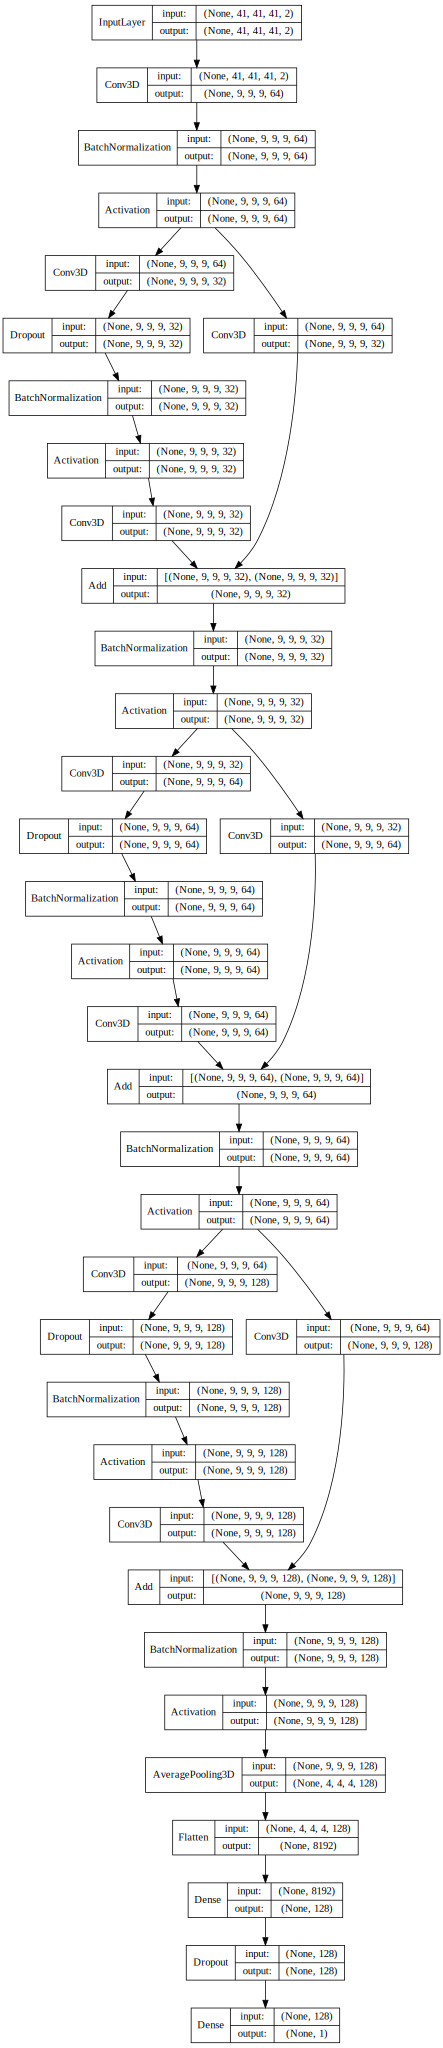

In [0]:
models['LargeVox'] = generate_resnet(x_train[0].shape, noise=False, l1_filters=64, l1_kernel_size=17, l1_dilation_rate=2)
SVG(model_to_dot(models['LargeVox'], show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))


In [0]:
models['LargeVox'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam()
)
history1 = models['LargeVox'].fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))
models['LargeVox'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)

)
history2 = models['LargeVox'].fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

histories['LargeVox'] = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'acc': history1.history['acc'] + history2.history['acc'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_acc': history1.history['val_acc'] + history2.history['val_acc'],

}

Train on 5400 samples, validate on 600 samples
Epoch 1/50
5400/5400 [==============================] - 52s 10ms/step - loss: 0.3929 - acc: 0.8813 - val_loss: 0.2846 - val_acc: 0.9233
Epoch 2/50
5400/5400 [==============================] - 41s 8ms/step - loss: 0.2030 - acc: 0.9348 - val_loss: 0.2988 - val_acc: 0.9050
Epoch 3/50
5400/5400 [==============================] - 42s 8ms/step - loss: 0.1908 - acc: 0.9387 - val_loss: 0.2194 - val_acc: 0.9300
Epoch 4/50
5400/5400 [==============================] - 42s 8ms/step - loss: 0.1852 - acc: 0.9422 - val_loss: 0.2037 - val_acc: 0.9283
Epoch 5/50
5400/5400 [==============================] - 42s 8ms/step - loss: 0.1669 - acc: 0.9437 - val_loss: 0.2725 - val_acc: 0.9133
Epoch 6/50
5400/5400 [==============================] - 42s 8ms/step - loss: 0.1507 - acc: 0.9457 - val_loss: 0.3405 - val_acc: 0.9250
Epoch 7/50
5400/5400 [==============================] - 42s 8ms/step - loss: 0.1382 - acc: 0.9419 - val_loss: 0.2010 - val_acc: 0.9267
Epoch 8

## Plot loss and accuracy

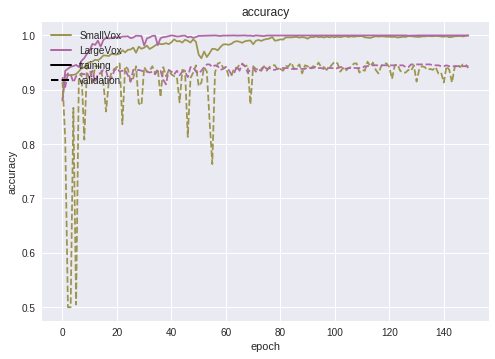

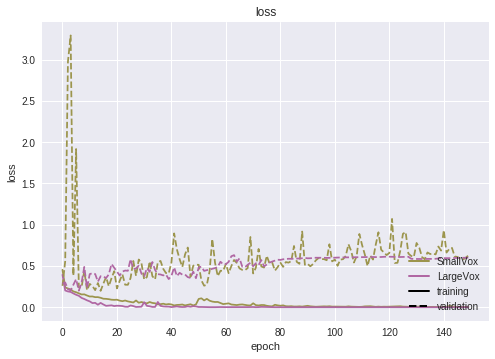

In [0]:
from matplotlib.lines import Line2D
# summarize history for accuracy
plt.plot(histories['SmallVox']['acc'], color='#9c954d')
plt.plot(histories['LargeVox']['acc'], color='#b067a3')
plt.plot(histories['SmallVox']['val_acc'], color='#9c954d', linestyle='--')
plt.plot(histories['LargeVox']['val_acc'], color='#b067a3', linestyle='--')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.ylim(top=1)
# plt.ylim(bottom=0.85)
legend_elements = [Line2D([0], [0], color='#9c954d', lw=2),
                    Line2D([0], [0], color='#b067a3', lw=2),
                    Line2D([0], [0], color='k', lw=2),
                    Line2D([0], [0], color='k', lw=2, linestyle='--')]
plt.legend(legend_elements, ['SmallVox', 'LargeVox', 'training', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histories['SmallVox']['loss'], color='#9c954d')
plt.plot(histories['LargeVox']['loss'], color='#b067a3')
plt.plot(histories['SmallVox']['val_loss'], color='#9c954d', linestyle='--')
plt.plot(histories['LargeVox']['val_loss'], color='#b067a3', linestyle='--')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.ylim(top=1.5)
# plt.ylim(bottom=0)
legend_elements = [Line2D([0], [0], color='#9c954d', lw=2),
                    Line2D([0], [0], color='#b067a3', lw=2),
                    Line2D([0], [0], color='k', lw=2),
                    Line2D([0], [0], color='k', lw=2, linestyle='--')]
plt.legend(legend_elements, ['SmallVox', 'LargeVox', 'training', 'validation'], loc='lower right')
plt.show()

# Tests with reducing false positives

In [0]:
models = {}
histories = {}

## Generate data and train ratio 1:1 model

In [0]:
x_all, y_all = generate_training_data(raw_training_data, max_dist=20, grid_resolution=4)
n = x_all.shape[0]
x_train = x_all[:int(n*0.9)]
y_train = y_all[:int(n*0.9)]
x_test = x_all[int(n*0.9):]
y_test = y_all[int(n*0.9):]

100%|██████████| 3000/3000 [00:11<00:00, 266.27it/s]


In [0]:
models['R11'] = generate_resnet(x_train[0].shape)

In [0]:
models['R11'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam()
)
history1 = models['R11'].fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))
models['R11'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)

)
history2 = models['R11'].fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

histories['R11'] = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'acc': history1.history['acc'] + history2.history['acc'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_acc': history1.history['val_acc'] + history2.history['val_acc'],

}

## Generate data and train ratio 1:2 model

In [0]:
x_all, y_all = generate_training_data(raw_training_data, neg_ratio=2, max_dist=20, grid_resolution=4)
n = x_all.shape[0]
x_train = x_all[:int(n*0.9)]
y_train = y_all[:int(n*0.9)]
x_test = x_all[int(n*0.9):]
y_test = y_all[int(n*0.9):]
print(x_train.shape[0])

100%|██████████| 3000/3000 [00:14<00:00, 200.20it/s]


8100


In [0]:
models['R12'] = generate_resnet(x_train[0].shape)

In [0]:
models['R12'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam()
)
history1 = models['R12'].fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))
models['R12'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)

)
history2 = models['R12'].fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

histories['R12'] = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'acc': history1.history['acc'] + history2.history['acc'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_acc': history1.history['val_acc'] + history2.history['val_acc'],

}

Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 41s 5ms/step - loss: 0.3205 - acc: 0.8962 - val_loss: 0.2403 - val_acc: 0.9100
Epoch 2/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1909 - acc: 0.9259 - val_loss: 0.4399 - val_acc: 0.8856
Epoch 3/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1670 - acc: 0.9344 - val_loss: 0.1958 - val_acc: 0.9344
Epoch 4/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1506 - acc: 0.9410 - val_loss: 0.1601 - val_acc: 0.9433
Epoch 5/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1401 - acc: 0.9456 - val_loss: 0.2098 - val_acc: 0.9289
Epoch 6/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1370 - acc: 0.9485 - val_loss: 0.1796 - val_acc: 0.9433
Epoch 7/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1314 - acc: 0.9538 - val_loss: 0.1516 - val_acc: 0.9422
Epoch 8/

## Generate data and train ratio 2:1 model

In [0]:
x_all, y_all = generate_training_data(raw_training_data, pos_ratio=2, max_dist=20, grid_resolution=4)
n = x_all.shape[0]
x_train = x_all[:int(n*0.9)]
y_train = y_all[:int(n*0.9)]
x_test = x_all[int(n*0.9):]
y_test = y_all[int(n*0.9):]
print(x_train.shape[0])

100%|██████████| 3000/3000 [00:19<00:00, 155.66it/s]


8100


In [0]:
models['R21'] = generate_resnet(x_train[0].shape)

In [0]:
models['R21'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam()
)
history1 = models['R21'].fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))
models['R21'].compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)

)
history2 = models['R21'].fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

histories['R21'] = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'acc': history1.history['acc'] + history2.history['acc'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_acc': history1.history['val_acc'] + history2.history['val_acc'],

}

Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 47s 6ms/step - loss: 0.3526 - acc: 0.9133 - val_loss: 1.6074 - val_acc: 0.4222
Epoch 2/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1864 - acc: 0.9469 - val_loss: 4.3687 - val_acc: 0.3333
Epoch 3/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1647 - acc: 0.9504 - val_loss: 2.1685 - val_acc: 0.3333
Epoch 4/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1572 - acc: 0.9498 - val_loss: 0.9999 - val_acc: 0.6511
Epoch 5/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1383 - acc: 0.9515 - val_loss: 0.2526 - val_acc: 0.9378
Epoch 6/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1295 - acc: 0.9516 - val_loss: 0.2472 - val_acc: 0.9411
Epoch 7/50
8100/8100 [==============================] - 29s 4ms/step - loss: 0.1207 - acc: 0.9544 - val_loss: 0.2711 - val_acc: 0.9344
Epoch 8/

## Generate data and train dynamic data generation model

In [0]:
models['Dynamic'] = generate_resnet(x_train[0].shape)

In [0]:
tbc=TensorBoardColab()
models['Dynamic'].compile(
    loss='binary_crossentropy',
    metrics=['acc', mcc],
    optimizer=Adam()
)
models['Dynamic'].fit_generator(
    generator=ProLigSequence(raw_training_train_data, batch_size=500),
    validation_data=ProLigSequence(raw_training_test_data, batch_size=500),
    epochs=100,
    initial_epoch=0,
    use_multiprocessing=True,
    callbacks=[ModelCheckpoint('Dynamic.h5',
                           monitor='val_mcc',
                           verbose=1,
                           save_best_only=True,
                           mode='max',
                           period=1),
              TensorBoardColabCallback(tbc)]
)
models['Dynamic'].compile(
    loss='binary_crossentropy',
    metrics=['acc', mcc],
    optimizer=SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)
)
models['Dynamic'].fit_generator(
    generator=ProLigSequence(raw_training_train_data, batch_size=500),
    validation_data=ProLigSequence(raw_training_test_data, batch_size=500),
    epochs=2900,
    initial_epoch=0,
    use_multiprocessing=True,
    callbacks=[ModelCheckpoint('Dynamic.h5',
                           monitor='val_mcc',
                           verbose=1,
                           save_best_only=True,
                           mode='max',
                           period=1),
              TensorBoardColabCallback(tbc)]
)

Wait for 8 seconds...
TensorBoard link:
https://d8386cd1.ngrok.io
Epoch 1/100
11/11 [==============================] - 27s 2s/step - loss: 1.0537 - acc: 0.9291 - mcc: 0.8648 - val_loss: 1.8325 - val_acc: 0.8850 - val_mcc: 0.7897

Epoch 00001: val_mcc improved from -inf to 0.78972, saving model to Dynamic.h5
Epoch 2/100
11/11 [==============================] - 22s 2s/step - loss: 0.9407 - acc: 0.9328 - mcc: 0.8688 - val_loss: 1.2725 - val_acc: 0.9133 - val_mcc: 0.8351

Epoch 00002: val_mcc improved from 0.78972 to 0.83512, saving model to Dynamic.h5
Epoch 3/100
11/11 [==============================] - 23s 2s/step - loss: 0.8889 - acc: 0.8731 - mcc: 0.7515 - val_loss: 2.0170 - val_acc: 0.5000 - val_mcc: 0.0000e+00

Epoch 00003: val_mcc did not improve from 0.83512
Epoch 4/100
11/11 [==============================] - 23s 2s/step - loss: 0.6570 - acc: 0.8655 - mcc: 0.7403 - val_loss: 1.3390 - val_acc: 0.5000 - val_mcc: 0.0000e+00

Epoch 00004: val_mcc did not improve from 0.83512
Epoch 5/1

## Plot loss and accuracy

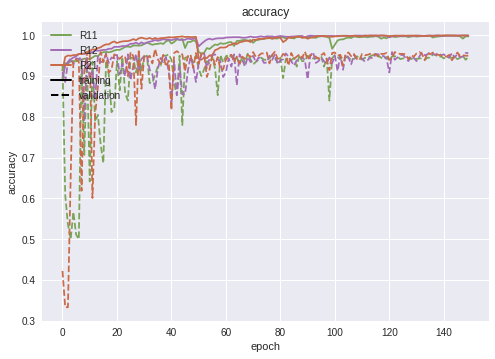

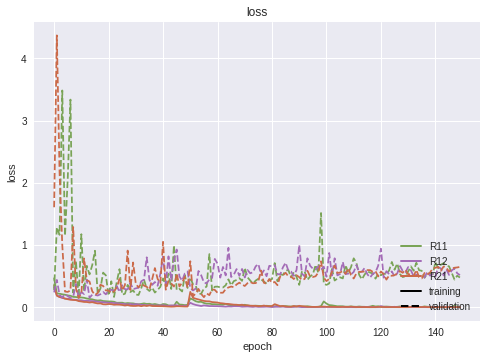

In [0]:
from matplotlib.lines import Line2D
# summarize history for accuracy
plt.plot(histories['R1']['acc'], color='#7aa457')
plt.plot(histories['R2']['acc'], color='#a46cb7')
plt.plot(histories['R21']['acc'], color='#cb6a49')
plt.plot(histories['R1']['val_acc'], color='#7aa457', linestyle='--')
plt.plot(histories['R2']['val_acc'], color='#a46cb7', linestyle='--')
plt.plot(histories['R21']['val_acc'], color='#cb6a49', linestyle='--')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.ylim(top=1)
# plt.ylim(bottom=0.85)
legend_elements = [Line2D([0], [0], color='#7aa457', lw=2),
                    Line2D([0], [0], color='#a46cb7', lw=2),
                    Line2D([0], [0], color='#cb6a49', lw=2),
                    Line2D([0], [0], color='k', lw=2),
                    Line2D([0], [0], color='k', lw=2, linestyle='--')]
plt.legend(legend_elements, ['R11', 'R12', 'R21', 'training', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histories['R1']['loss'], color='#7aa457')
plt.plot(histories['R2']['loss'], color='#a46cb7')
plt.plot(histories['R21']['loss'], color='#cb6a49')
plt.plot(histories['R1']['val_loss'], color='#7aa457', linestyle='--')
plt.plot(histories['R2']['val_loss'], color='#a46cb7', linestyle='--')
plt.plot(histories['R21']['val_loss'], color='#cb6a49', linestyle='--')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.ylim(top=1.5)
# plt.ylim(bottom=0)
legend_elements = [Line2D([0], [0], color='#7aa457', lw=2),
                    Line2D([0], [0], color='#a46cb7', lw=2),
                    Line2D([0], [0], color='#cb6a49', lw=2),
                    Line2D([0], [0], color='k', lw=2),
                    Line2D([0], [0], color='k', lw=2, linestyle='--')]
plt.legend(legend_elements, ['R11', 'R12', 'R21', 'training', 'validation'], loc='lower right')
plt.show()

# Plot confusion matrix

In [0]:
x_all, y_all = generate_training_data(raw_training_data, neg_ratio=10, max_dist=20, grid_resolution=4)
n = x_all.shape[0]
x_train = x_all[:int(n*0.9)]
y_train = y_all[:int(n*0.9)]
x_test = x_all[int(n*0.9):]
y_test = y_all[int(n*0.9):]

100%|██████████| 3000/3000 [00:40<00:00, 69.73it/s]


Normalized confusion matrix
[[0.92       0.08      ]
 [0.02666667 0.97333333]]


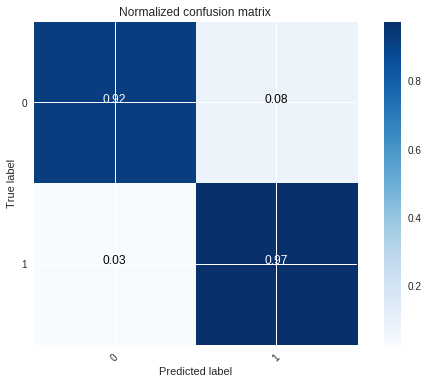

In [0]:
y_pred = models['R1'].predict(x_test)
y_pred = np.piecewise(y_pred, [y_pred < 0.5, y_pred >= 0.5], [0., 1.])
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')


Normalized confusion matrix
[[0.95666667 0.04333333]
 [0.05       0.95      ]]


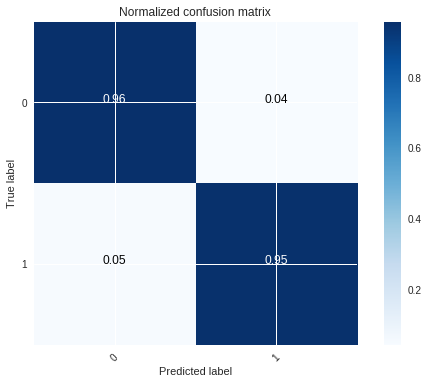

In [0]:
y_pred = models['R2'].predict(x_test)
y_pred = np.piecewise(y_pred, [y_pred < 0.5, y_pred >= 0.5], [0., 1.])
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')


Normalized confusion matrix
[[0.90333333 0.09666667]
 [0.02666667 0.97333333]]


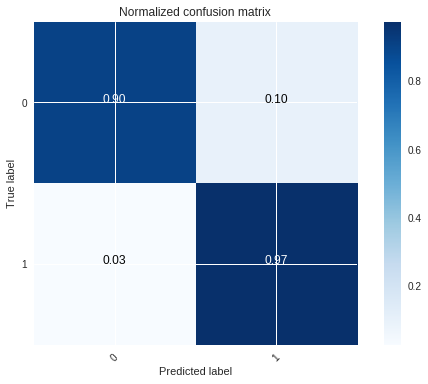

In [0]:
y_pred = models['R21'].predict(x_test)
y_pred = np.piecewise(y_pred, [y_pred < 0.5, y_pred >= 0.5], [0., 1.])
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')


600/600 [==============================] - 7s 11ms/step
Normalized confusion matrix
[[0.97666667 0.02333333]
 [0.02333333 0.97666667]]


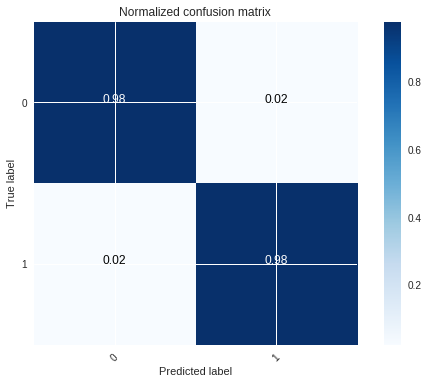

In [0]:
# models['Best'] = load_model('Dynamic.h5')
y_pred = models['Best'].predict(x_test, batch_size=1000, verbose=1)
y_pred = np.piecewise(y_pred, [y_pred < 0.5, y_pred >= 0.5], [0., 1.])
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')


# Predict the test data

## Download test data

In [0]:
!wget https://web.bii.a-star.edu.sg/~leehk/cs5242_project/testing_data_release.zip
!unzip testing_data_release.zip

## Load testing data into memory

In [0]:
raw_testing_data = {
    'pro': [],
    'lig': []
}
for i in trange(824):
    raw_testing_data['pro'].append(
        read_test_pdb("./testing_data_release/testing_data/{:04d}_pro_cg.pdb".format(i + 1)))
    raw_testing_data['lig'].append(
        read_test_pdb("./testing_data_release/testing_data/{:04d}_lig_cg.pdb".format(i + 1)))

100%|██████████| 824/824 [00:01<00:00, 461.96it/s]


## Define test data voxels generator

In [0]:
def test_generator(raw_data, n=None, max_dist=20, grid_resolution=4):
    if n is None:
        n = len(raw_data['pro'])
    for i in range(n):
        x_test = []
        for j in range(n):
            grid = voxelize((raw_data['pro'][i], raw_data['lig'][j]),
                     max_dist=max_dist,
                     grid_resolution=grid_resolution);
            x_test.append(grid[0])
        yield(np.asarray(x_test))

## Define function predict with model on test data

In [0]:
def predict_test_on_model(model, test_gen, length):
    predictions = []
    for test in tqdm(test_gen, total=length):
        pred = model.predict(test, batch_size=824)
        pred = np.reshape(pred, len(pred))
        predictions.append(pred)
    return predictions

def save_top10(predictions, filename='training_predictions.txt'):
    n = len(predictions)
    top10each = []
    for i in range(n):
        top10 = np.argpartition(predictions[i], -10)[-10:]
        top10 = top10 + 1
        top10each.append(top10)
    with open(filename, 'w') as f:
        f.write("\t".join(["pro_id"] + ["lig{}_id".format(i) for i in range(1, 11)]) + "\n")
        for i in range(n):
            f.write("{}\t".format(i+1) + "\t".join(str(x) for x in top10each[i]) + "\n")

def generate_ground_truth(n):
    with open('test_ground_truth_example.txt', 'w') as f:
        f.write("\t".join(["pro_id", "lig_id"]) + "\n")
        for i in range(n):
            f.write("{}\t{}".format(i+1, i+1) + "\n")

## Test predictions on training dataset

In [0]:
predictions = predict_test_on_model(
    models['Best'],
    test_generator(raw_training_data, n=500, max_dist=20, grid_resolution=4),
    length=500
)

100%|██████████| 500/500 [09:24<00:00,  1.14s/it]


In [0]:
save_top10(predictions, 'test_predictions_example.txt')
generate_ground_truth(500)

## Generate test accuracy

In [0]:
!cp ./testing_data_release/calculate_top_10_acc.py ./

In [0]:
!python ./calculate_top_10_acc.py

accuracy:0.920


## Predict on testing dataset

In [0]:
predictions = predict_test_on_model(
    models['Best'],
    test_generator(raw_testing_data, max_dist=20, grid_resolution=4),
    length=len(raw_testing_data['pro'])
)
save_top10(predictions)



100%|██████████| 824/824 [22:48<00:00,  1.45s/it]
